# Mini-Project 1: Machine Learning 101

Christian Martel (260867191)

Luka Loignon

Marie Guertin

# PART I: Adult Dataset

Prediction task is to determine whether someone makes over 50K a year.
https://archive.ics.uci.edu/ml/datasets/Adult

## Imports and Setup

In [14]:
import pandas as pd
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Data Preprocessing

Acquire data, analyze it and clean it

In [7]:
# 13 feature columns and 2 prediction columns
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# 1) IMPORT DATA
train_df = pd.read_csv("data/adult.data", usecols = range(15), names = columns)
test_df = pd.read_csv("data/adult.test", usecols = range(15), names = columns)

# 2) CLEAN-UP
train_df_obj = train_df.select_dtypes(['object'])
test_df_obj = test_df.select_dtypes(['object'])

train_df[train_df_obj.columns] = train_df_obj.apply(lambda x: x.str.strip())
test_df[test_df_obj.columns] = test_df_obj.apply(lambda x: x.str.strip())


# 3) REMOVE USELESS FEATURES
# count number of zeros or nan values per column and drop columns with more than 75% of 0 or nan values
num_instances = train_df.shape[0]
useless_data_threshold = 0.75

for c in columns:
    useless_proportion = (train_df[c].isna().sum() + (train_df[c] == 0).sum()) / num_instances
    if useless_proportion > useless_data_threshold:
        train_df.drop(columns = c, inplace = True)
        test_df.drop(columns = c, inplace = True)

# 4) FEATURE ONE_HOT_ENCODING 

for cat in categorical_columns:    
    # concatenante one hot encoded dummies columns
    train_df, test_df = pd.concat([train_df, pd.get_dummies(train_df[cat], prefix = cat, prefix_sep = '_')], axis = 1), pd.concat([test_df, pd.get_dummies(train_df[cat], prefix = cat, prefix_sep = '_')], axis = 1)
    
    # drop old columns
    train_df, test_df = train_df.drop(columns = cat), test_df.drop(columns = cat)
    
# 5) MOVE PREDICTION COLUMN TO THE END

y_train, y_test = train_df.pop('salary'), test_df.pop('salary')
train_df, test_df = pd.concat([train_df, y_train],axis=1), pd.concat([test_df, y_test],axis=1)


# 6) NUMERIZE PREDICTION VARIABLE

# - '>50K': 1
# - '<=50K': 0
train_df['salary'] = train_df['salary'].apply(lambda x: 1 if (x == '>50K') else 0)
train_df

,age,fnlwgt,education-num,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_?,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_?,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,salary
0,39,77516,13,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,38,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

## Cross Validation

helper method to perform the splits for L-fold cross-validation

In [8]:
def cross_validate_splits(n, n_folds=5):
    # get the number of data samples in each split
    splits = []
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        # get the validation indexes
        val_inds = list(range(f * n_val, (f+1) * n_val))
        
        # get the training indexes
        tr_inds = list()
        if f < n_folds - 1:
            tr_inds = list(range((f+1) * n_val, n))
        
        if f > 0:
            tr_inds = tr_inds + list(range(0, f * n_val))
        splits.append((tr_inds, val_inds))
    return splits

## Validation Metrics

In [9]:
# define MSE loss function
loss = lambda y, y_pred: np.mean((y-y_pred)**2)

#define accuracy function
accuracy = lambda y, y_pred: np.sum(y == y_pred)/y.size

## KNN


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# convert to numpy arrays
train, test = train_df.to_numpy(), test_df.to_numpy()

x, y = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

num_instances = train.shape[0]

# range of K values to test
K_list = list(range(1,30)) 

# number of folds for L-fold cross-validation
L = 5

# l-fold cross validation splits
n_folds_splits = cross_validate_splits(num_instances, n_folds=L)


# compare models for different K parameters

# K x L matrix
err_matrix, acc_matrix = np.zeros((len(K_list),L)), np.zeros((len(K_list),L))

for i, K in enumerate(K_list):
    model = KNeighborsClassifier(n_neighbors=K)
    for j, split in enumerate(n_folds_splits):
        # split into train set and validation set
        x_train, x_val = x[split[0], :], x[split[1], :]
        y_train, y_val = y[split[0]], y[split[1]]

        model.fit(x_train, y_train)
        
        y_pred = model.predict(x_val)
        err_val = loss(y_val, y_pred)
        acc_val = accuracy(y_val, y_pred)
        
        err_matrix[i][j] = err_val
        acc_matrix[i][j] = acc_val

### Visualization

1. MSE vs Number of NN (K)
2. Accuracy vs Number of NN (K)

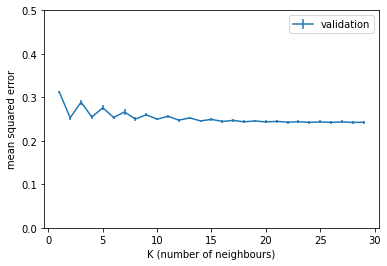

In [24]:
plt.errorbar(K_list, np.mean(err_matrix, axis=1), np.std(err_matrix, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.ylim(0,0.5)
plt.show()

In [ ]:
plt.errorbar(K_list, np.mean(acc_matrix, axis=1), np.std(acc_matrix, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('model accuracy')
plt.ylim(0,1)
plt.show()

## Sample Growing Data

Test with different training data sizes